<font size=5>**Turbofan Engine Remaining Usefel Lifetime Prediction**</font>

---

In [1]:
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

### Data Loading

In [2]:
path_to_raw = '../data/raw/CMAPSSData/train/'
path_to_processed = '../data/processed/train/'

# get all train dataset filenames
raw_files = sorted(glob.glob(path_to_raw+'*'))

In [3]:
# header
header = [ 'unit_id', 'time_cycle','op_set_1', 'op_set_2', 'op_set_3', 'sensor_1',
           'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7',
           'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12',
           'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
           'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'
         ]



In [4]:
# upload data
raw_data = pd.read_csv(raw_files[0], sep=' ', header=None, )

# drop empty columns (last 2 cols)
raw_data.dropna(axis=1, inplace=True)

# drop duplicate entry
raw_data.drop_duplicates(inplace=True)

# rename header
raw_data.set_axis(labels=header, axis=1, inplace=True)

In [5]:
# create new max_cycle df, each unit have their own max_cycle
max_cycle = raw_data.groupby('unit_id', sort=False)['time_cycle'].max().to_frame('max_cycle').reset_index()

# merge raw_data with max_cycle
df = pd.merge(raw_data, max_cycle, how='inner', on='unit_id')

# compute RUL
df['RUL'] = df['max_cycle'] - df['time_cycle']

In [6]:
df.head()

,unit_id,time_cycle,op_set_1,op_set_2,op_set_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187


### Pairwise correlation

<AxesSubplot:title={'center':'../data/raw/CMAPSSData/train/train_FD001.txt'}>

<Figure size 432x288 with 0 Axes>

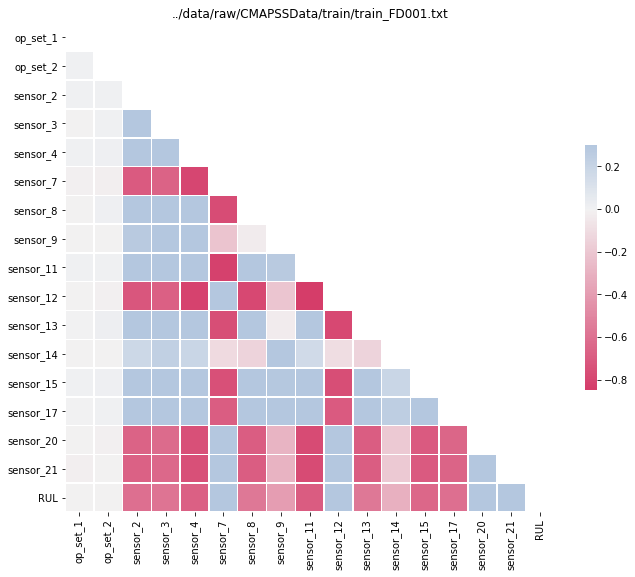

In [7]:
# id, constant, quasi-constant features to be removed
to_drop = ['unit_id', 'time_cycle', 'max_cycle']
constant_features = ['op_set_3', 'sensor_18', 'sensor_19']
quasi_cons_features = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16']

# corr = df.drop(to_drop, axis=1).corr()
corr = df.drop(to_drop+constant_features+quasi_cons_features, axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure()
f, ax = plt.subplots(figsize=(11, 9))

# Set title as filename
plt.title(raw_files[0])

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 250, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data=corr, annot=False, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Set treshold 

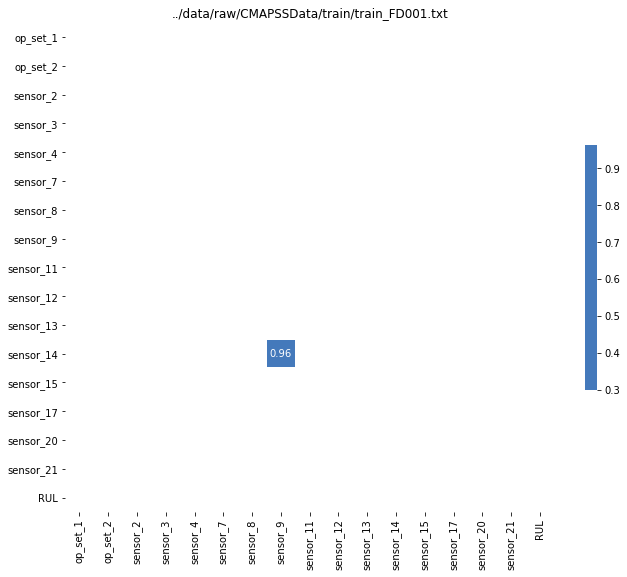

Most correlated pairwise : 


,corr_coef
sensor_9,0.963157
sensor_14,0.963157


In [8]:
# set treshold
tresh = 0.90
high_corr = corr[((corr >= tresh) | (corr <= -tresh)) & (corr !=1.000)]

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Set title as filename
plt.title(raw_files[0])

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 250, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(high_corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

print('Most correlated pairwise : ')
hc = high_corr.max().to_frame('corr_coef')
hc[hc['corr_coef'] > tresh].sort_values(by='corr_coef', ascending=False)

### Visualization

#### Maximum cycles

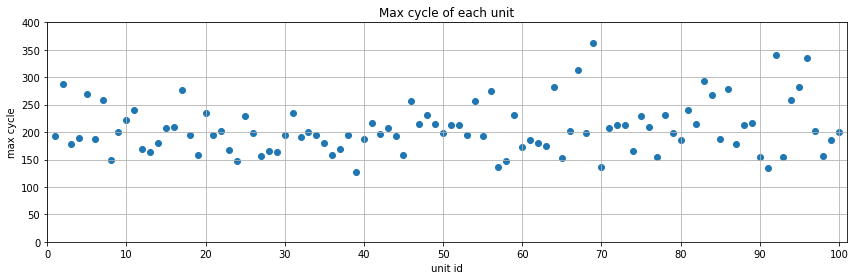

In [9]:
# maximum cycle dataframe
df_max = df[['unit_id', 'max_cycle']].groupby('unit_id').max().reset_index()

plt.figure(figsize=(12,4))
plt.title('Max cycle of each unit')

plt.scatter(x=df_max['unit_id'], y=df_max['max_cycle'], cmap=df_max['unit_id'])

plt.xlabel('unit id')
plt.ylabel('max cycle')
plt.xticks(np.arange(0, 101, step=10))
plt.xlim(0, 101)
plt.ylim(0, 400)
plt.xticks()
plt.grid()
plt.tight_layout()
plt.show()

#### Pairplot

In [10]:
# sns.set(style="ticks")
# def hide_current_axis(*args, **kwds):
#     plt.gca().set_visible(False)
    
# data = df.drop(to_drop+constant_features+quasi_cons_features, axis=1)

# g = sns.PairGrid(data, diag_sharey=False)
# g.map_lower(sns.scatterplot, alpha=0.3, edgecolor='none')
# g.map_diag(sns.histplot, multiple="stack", element="step")
# g.map_upper(hide_current_axis)

#### Constant & Quasi-constant features

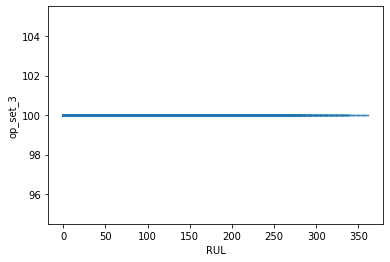

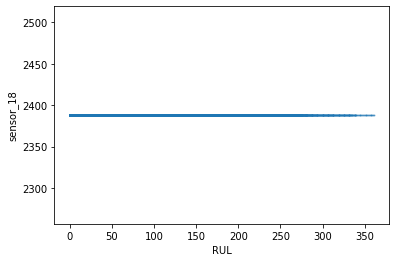

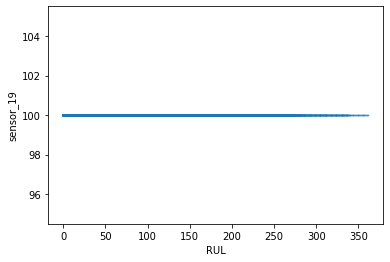

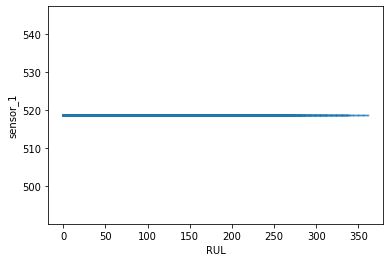

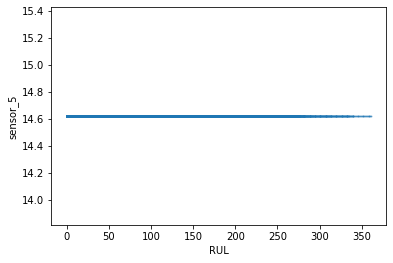

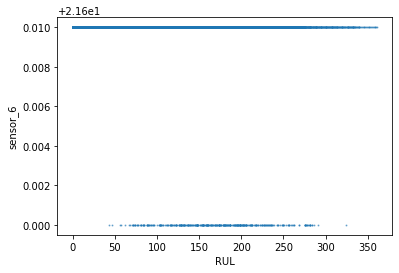

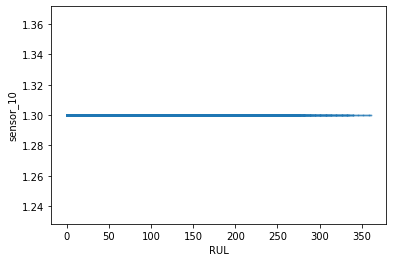

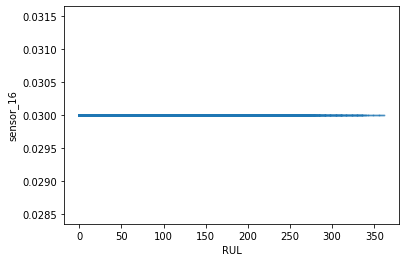

In [11]:
df_cst = df[constant_features + quasi_cons_features + ['RUL', 'unit_id']]

for col in df_cst.columns[:-2]:
    plt.figure()
    plt.scatter(x=df_cst['RUL'], y=df_cst[col], alpha=0.5, s=1)
    plt.ylabel(col)
    plt.xlabel('RUL')
    plt.show()    

#### Varying features

In [12]:
vary_features = [x for x in header if x not in constant_features] + ['RUL']

In [13]:
vary_features

['unit_id',
 'time_cycle',
 'op_set_1',
 'op_set_2',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'sensor_6',
 'sensor_7',
 'sensor_8',
 'sensor_9',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_15',
 'sensor_16',
 'sensor_17',
 'sensor_20',
 'sensor_21',
 'RUL']

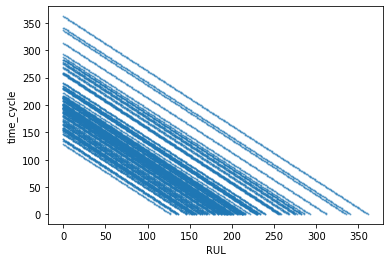

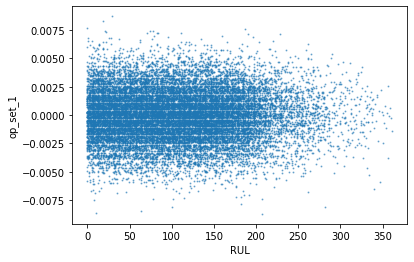

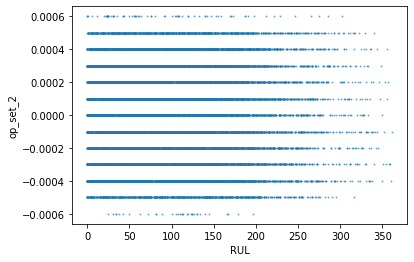

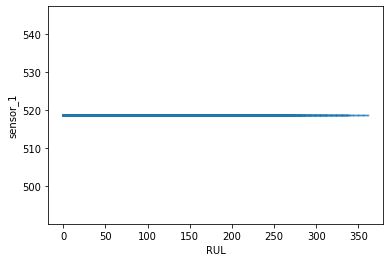

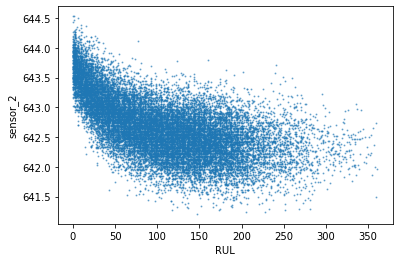

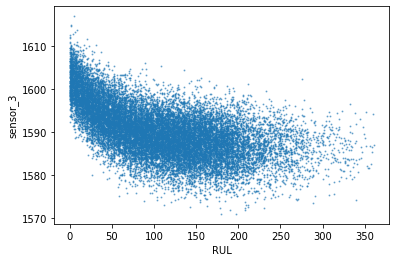

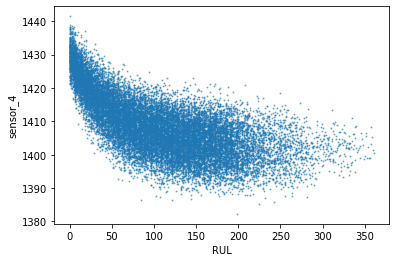

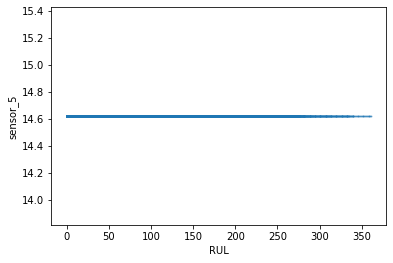

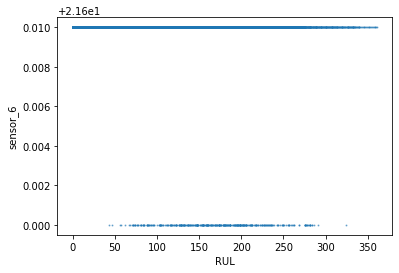

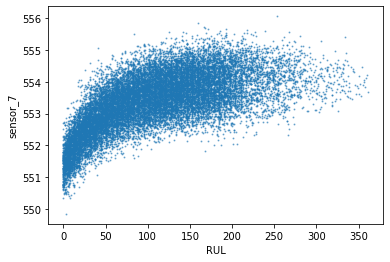

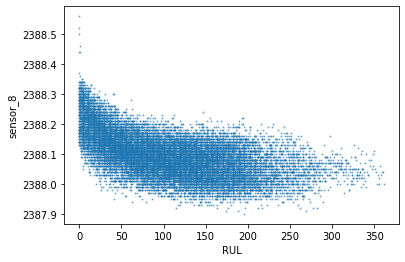

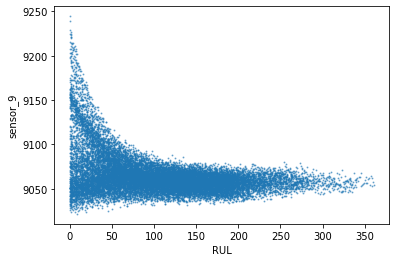

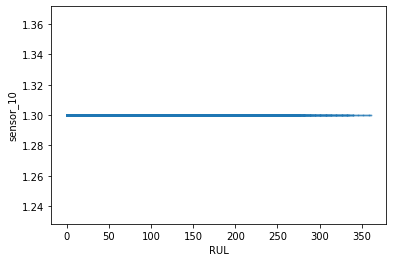

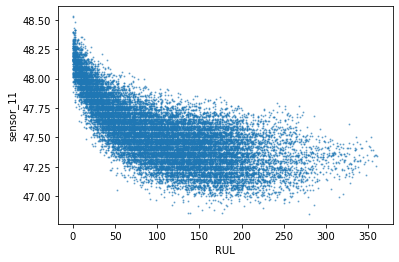

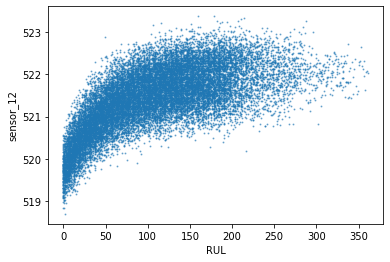

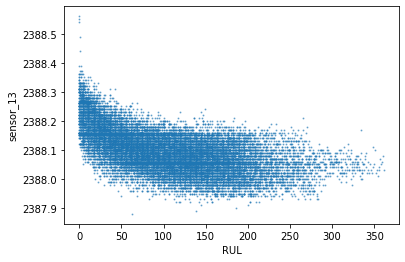

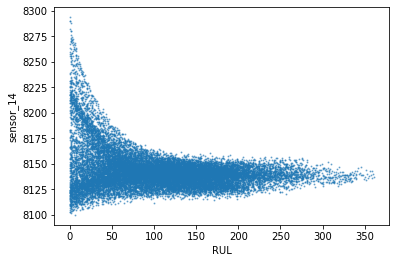

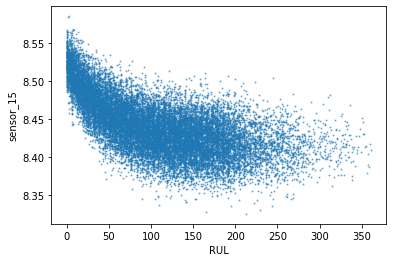

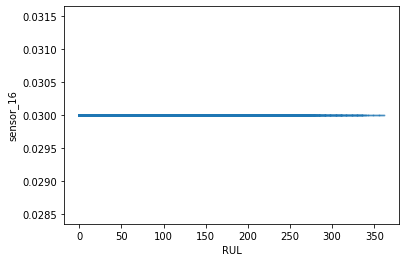

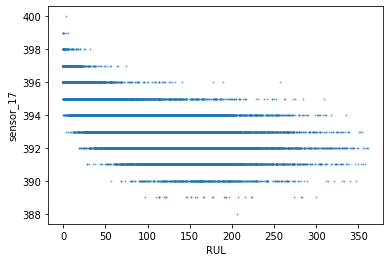

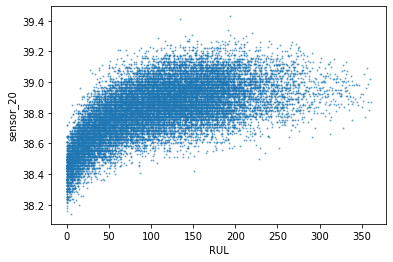

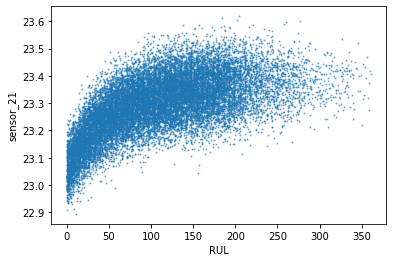

In [14]:
df_vary = df[vary_features]

for col in df_vary.columns[1:-1]:
    plt.figure()
    plt.scatter(x=df_vary['RUL'], y=df_vary[col], alpha=0.5, s=1)
    plt.ylabel(col)
    plt.xlabel('RUL')
    plt.show()    

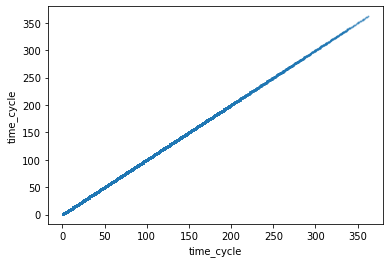

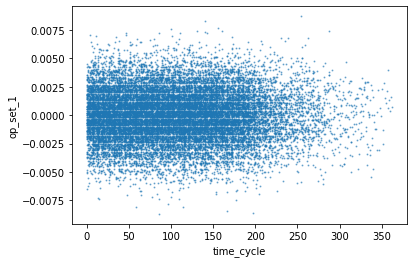

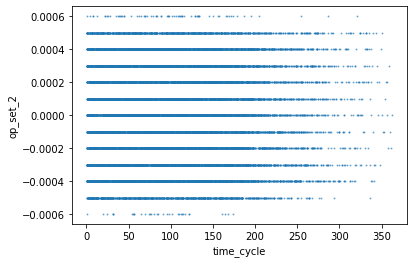

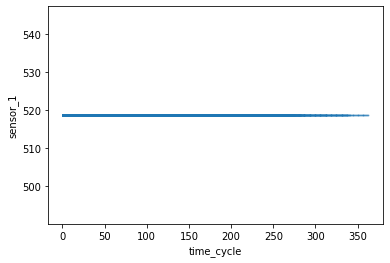

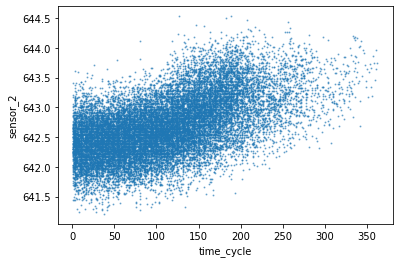

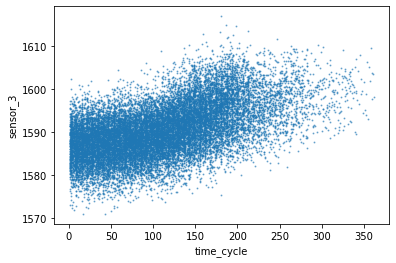

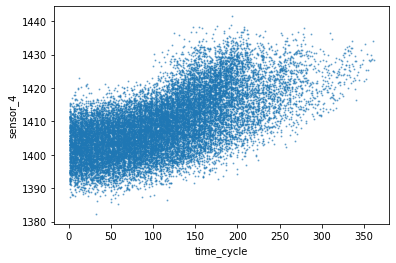

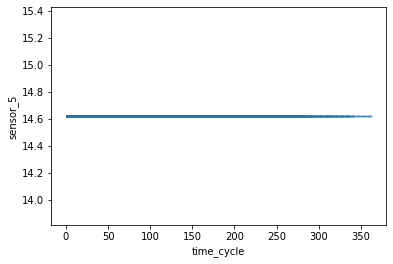

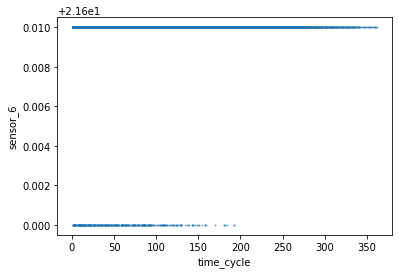

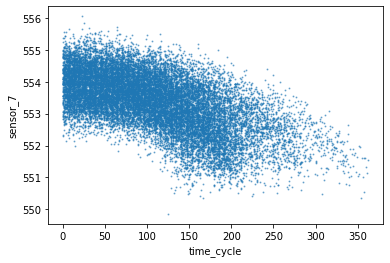

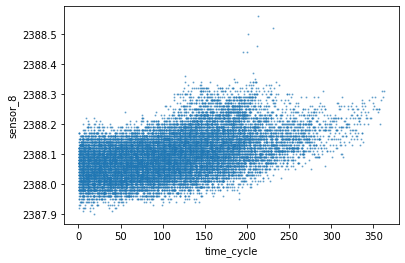

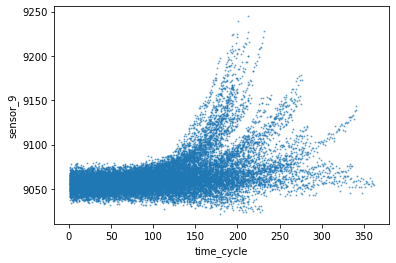

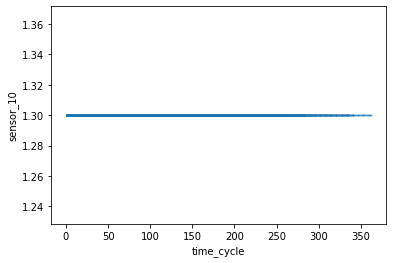

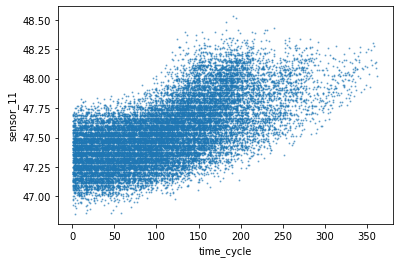

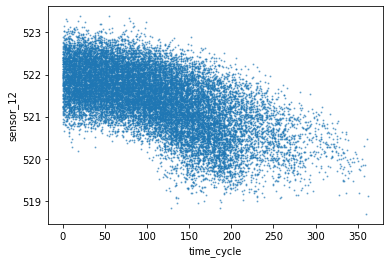

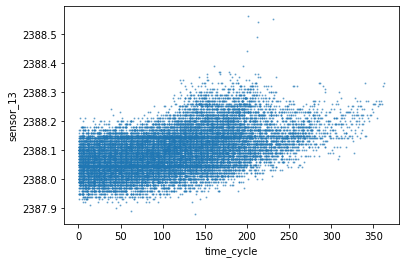

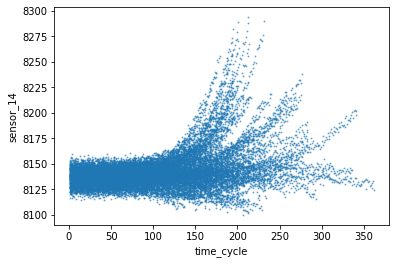

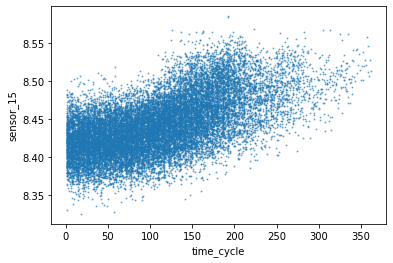

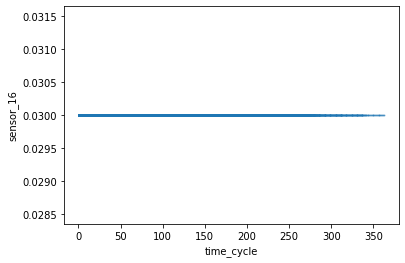

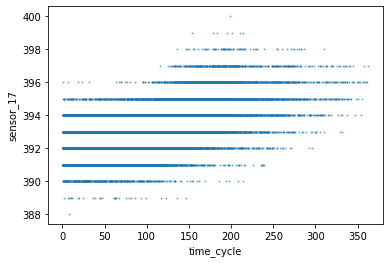

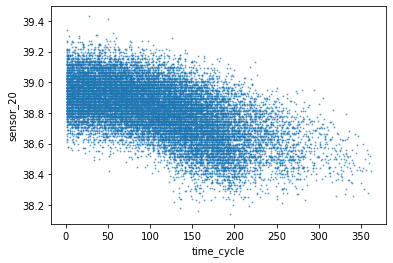

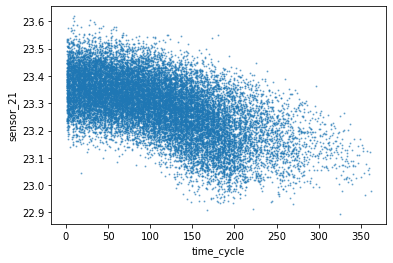

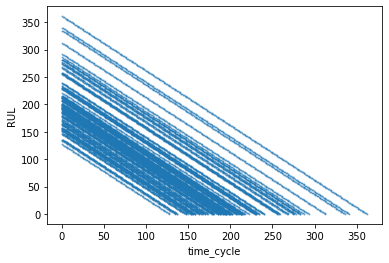

In [15]:
df_vary = df[vary_features]

for col in df_vary.columns[1:]:
    plt.figure()
    plt.scatter(x=df_vary['time_cycle'], y=df_vary[col], alpha=0.5, s=1)
    plt.ylabel(col)
    plt.xlabel('time_cycle')
    plt.show()    

### Saving to data/processed

In [16]:
raw_files

['../data/raw/CMAPSSData/train/train_FD001.txt',
 '../data/raw/CMAPSSData/train/train_FD002.txt',
 '../data/raw/CMAPSSData/train/train_FD003.txt',
 '../data/raw/CMAPSSData/train/train_FD004.txt']

In [19]:
path_to_processed_train = '../data/processed/train/'

# header
header = [ 'unit_id', 'time_cycle','op_set_1', 'op_set_2', 'op_set_3', 'sensor_1',
           'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7',
           'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12',
           'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17',
           'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'
         ]


for file in raw_files:
    
    # upload data
    raw_data = pd.read_csv(file, sep=' ', header=None, )

    # drop empty columns (last 2 cols)
    raw_data.dropna(axis=1, inplace=True)

    # drop duplicate entry
    raw_data.drop_duplicates(inplace=True)

    # rename header
    raw_data.set_axis(labels=header, axis=1, inplace=True)

    # create new max_cycle df, each unit have their own max_cycle
    max_cycle = raw_data.groupby('unit_id', sort=False)['time_cycle'].max().to_frame('max_cycle').reset_index()

    # merge raw_data with max_cycle
    df = pd.merge(raw_data, max_cycle, how='inner', on='unit_id')

    # compute RUL
    df['RUL'] = df['max_cycle'] - df['time_cycle']
    
    # save to csv file
    df.to_csv(path_to_processed_train+file[-9:-4]+'_processed.csv', index=False)

In [20]:
!ls -lh ../data/processed/train/

total 27M
-rw-r--r-- 1 hazmilh hazmilh 3.4M Nov 27 19:25 FD001_processed.csv
-rw-r--r-- 1 hazmilh hazmilh 8.8M Nov 27 19:25 FD002_processed.csv
-rw-r--r-- 1 hazmilh hazmilh 4.1M Nov 27 19:25 FD003_processed.csv
-rw-r--r-- 1 hazmilh hazmilh  10M Nov 27 19:25 FD004_processed.csv
